# 03 – Multimodal Biomass Model (Images + Tabular, 5 outputs)

In this notebook we build a **multimodal deep learning model** that combines:

- **RGB pasture images** (processed by a pretrained CNN backbone), and  
- **tabular features** (NDVI, height, metadata),

to jointly predict the five biomass components:

- `Dry_Clover_g`
- `Dry_Dead_g`
- `Dry_Green_g`
- `Dry_Total_g`
- `GDM_g`

The model will have **five outputs**, one per biomass component, sharing a common image + tabular representation.  
We start with a relatively simple architecture (frozen CNN backbone + small MLP for tabular features) and a basic training loop, and we will later iterate on:

- fine-tuning,
- adding richer tabular features (categoricals, seasonal encoding),
- custom loss matching the competition’s weighted R².

In [1]:
# ============================================================
# 03_Multimodal_BiomassModel.ipynb
# ------------------------------------------------------------
# Base setup: imports, paths, train loading
# ============================================================

import os
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Paths (ajustar caso o notebook estja em outra pasta)
BASE_DIR = Path(".")  # raiz do projeto
TRAIN_CSV = BASE_DIR / "train.csv"     # já usamos esse no EDA
TRAIN_IMG_DIR = BASE_DIR               # porque image_path já tem "train/ID....jpg"

train = pd.read_csv(TRAIN_CSV)
print(train.head())
print(train.shape)

                    sample_id              image_path Sampling_Date State  \
0  ID1011485656__Dry_Clover_g  train/ID1011485656.jpg      2015/9/4   Tas   
1    ID1011485656__Dry_Dead_g  train/ID1011485656.jpg      2015/9/4   Tas   
2   ID1011485656__Dry_Green_g  train/ID1011485656.jpg      2015/9/4   Tas   
3   ID1011485656__Dry_Total_g  train/ID1011485656.jpg      2015/9/4   Tas   
4         ID1011485656__GDM_g  train/ID1011485656.jpg      2015/9/4   Tas   

           Species  Pre_GSHH_NDVI  Height_Ave_cm   target_name   target  
0  Ryegrass_Clover           0.62         4.6667  Dry_Clover_g   0.0000  
1  Ryegrass_Clover           0.62         4.6667    Dry_Dead_g  31.9984  
2  Ryegrass_Clover           0.62         4.6667   Dry_Green_g  16.2751  
3  Ryegrass_Clover           0.62         4.6667   Dry_Total_g  48.2735  
4  Ryegrass_Clover           0.62         4.6667         GDM_g  16.2750  
(1785, 9)


In [2]:
# ============================================================
# Convert long format (one row per image/target_name)
# → wide format (one row per image, 5 targets)
# ============================================================

# Garantir tipos corretos de data, season etc
if not np.issubdtype(train["Sampling_Date"].dtype, np.datetime64):
    train["Sampling_Date"] = pd.to_datetime(train["Sampling_Date"])

# Extrair um ID de imagem mais simples (se quiser)
train["image_id"] = train["image_path"].str.extract(r"(ID\d+)")

# Pivot: um row por image_id / image_path
pivot_index_cols = [
    "image_id",
    "image_path",
    "Sampling_Date",
    "State",
    "Species",
    "Pre_GSHH_NDVI",
    "Height_Ave_cm",
]

wide = (
    train
    .pivot_table(
        index=pivot_index_cols,
        columns="target_name",
        values="target"
    )
    .reset_index()
)

# Reordenar colunas de target num vetor fixo (importante para o modelo multimodal com 5 targs)
target_order = ["Dry_Clover_g", "Dry_Dead_g", "Dry_Green_g", "Dry_Total_g", "GDM_g"]
wide = wide[pivot_index_cols + target_order]

print(wide.head())
print("Wide shape:", wide.shape)

target_name      image_id              image_path Sampling_Date State  \
0            ID1011485656  train/ID1011485656.jpg    2015-09-04   Tas   
1            ID1012260530  train/ID1012260530.jpg    2015-04-01   NSW   
2            ID1025234388  train/ID1025234388.jpg    2015-09-01    WA   
3            ID1028611175  train/ID1028611175.jpg    2015-05-18   Tas   
4            ID1035947949  train/ID1035947949.jpg    2015-09-11   Tas   

target_name            Species  Pre_GSHH_NDVI  Height_Ave_cm  Dry_Clover_g  \
0              Ryegrass_Clover           0.62         4.6667        0.0000   
1                      Lucerne           0.55        16.0000        0.0000   
2            SubcloverDalkeith           0.38         1.0000        6.0500   
3                     Ryegrass           0.66         5.0000        0.0000   
4                     Ryegrass           0.54         3.5000        0.4343   

target_name  Dry_Dead_g  Dry_Green_g  Dry_Total_g    GDM_g  
0               31.9984      16

In [3]:
# ============================================================
# Basic tabular features + group-aware train/val split
# ============================================================

# Simple numeric features for now
tab_features = ["Pre_GSHH_NDVI", "Height_Ave_cm"]

# Target matrix (N_imgs, 5)
y_cols = target_order
y = wide[y_cols].values.astype("float32")

# Groups for split (to avoid leakage between variants of same image)
groups = wide["image_id"].values

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(gss.split(wide, groups=groups))

wide_train = wide.iloc[train_idx].reset_index(drop=True)
wide_val   = wide.iloc[val_idx].reset_index(drop=True)

print("Train images:", len(wide_train), "Val images:", len(wide_val))

Train images: 285 Val images: 72


In [5]:
# ============================================================
# Load precomputed EfficientNet embeddings & merge
# ============================================================

import os

EMB_PATH = os.path.join(BASE_DIR, "embeddings", "image_embeddings.csv")
print("Loading embeddings from:", EMB_PATH)

emb = pd.read_csv(EMB_PATH)
print("Embeddings loaded:", emb.shape)

# Guarantee image_id exists
if "image_id" not in emb.columns:
    if "image_path" in emb.columns:
        emb["image_id"] = emb["image_path"].str.extract(r"(ID\d+)")
    else:
        raise ValueError("Embeddings CSV must contain 'image_id' or 'image_path'.")

# Identify embedding columns
emb_cols = [c for c in emb.columns if c.startswith("emb_")]
print(f"Detected {len(emb_cols)} embedding dims.")

# Merge into the wide table
wide = wide.merge(
    emb[["image_id"] + emb_cols],
    on="image_id",
    how="left"
)

print("Merged wide table:", wide.shape)

# Count missing embeddings
missing = wide[emb_cols].isna().sum().sum()
print("Missing embedding values:", missing)

# Option 1 — drop missing (recommended)
if missing > 0:
    wide = wide.dropna(subset=emb_cols).reset_index(drop=True)
    print("After dropping missing embeddings:", wide.shape)


Loading embeddings from: ./embeddings/image_embeddings.csv
Embeddings loaded: (357, 51)
Detected 50 embedding dims.
Merged wide table: (357, 62)
Missing embedding values: 0


In [8]:
# ============================================================
# Prepare image embedding matrices (X_train_img / X_val_img)
# ============================================================

# Identify embedding columns (should be emb_0, emb_1, ..., emb_49)
emb_cols = [c for c in wide.columns if c.startswith("emb_")]
print("Embedding columns found:", len(emb_cols))

# Apply the same split indices used before
wide_train = wide.iloc[train_idx].reset_index(drop=True)
wide_val   = wide.iloc[val_idx].reset_index(drop=True)

# Extract embedding arrays
X_train_img = wide_train[emb_cols].values.astype("float32")
X_val_img   = wide_val[emb_cols].values.astype("float32")

print("Image embedding shapes:")
print("Train:", X_train_img.shape)
print("Val:",   X_val_img.shape)

Embedding columns found: 50
Image embedding shapes:
Train: (285, 50)
Val: (72, 50)


In [11]:
# ============================================================
# Define full tabular features + preprocessing
# ============================================================

# Add temporal features: year, month, season
wide_train["year"] = wide_train["Sampling_Date"].dt.year
wide_train["month"] = wide_train["Sampling_Date"].dt.month
wide_train["Season"] = wide_train["Sampling_Date"].dt.month % 12 // 3 + 1

wide_val["year"] = wide_val["Sampling_Date"].dt.year
wide_val["month"] = wide_val["Sampling_Date"].dt.month
wide_val["Season"] = wide_val["Sampling_Date"].dt.month % 12 // 3 + 1

# ---- Select tabular features ----
num_features = [
    "Pre_GSHH_NDVI",
    "Height_Ave_cm",
    "month",
    "Season",
]

cat_features = [
    "State",
    "Species",
]

all_features = num_features + cat_features

# ---- Target matrix (N_imgs, 5 outputs) ----
y_train = wide_train[y_cols].values.astype("float32")
y_val   = wide_val[y_cols].values.astype("float32")

# ---- Preprocessing pipelines ----
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_features),
    ]
)

# Fit on training, transform both sets
X_train_tab = preprocessor.fit_transform(wide_train)
X_val_tab   = preprocessor.transform(wide_val)

print("Tabular feature matrix shapes:")
print("X_train_tab:", X_train_tab.shape)
print("X_val_tab:", X_val_tab.shape)
print("Targets:", y_train.shape, y_val.shape)

Tabular feature matrix shapes:
X_train_tab: (285, 23)
X_val_tab: (72, 23)
Targets: (285, 5) (72, 5)


In [12]:
# ============================================================
# Multimodal Dataset (Tabular + Image Embeddings)
# ============================================================

import torch
from torch.utils.data import Dataset, DataLoader

class PastureDataset(Dataset):
    """
    Dataset multimodal:
      - tabular features (scaled + encoded)
      - image embeddings (precomputed EfficientNet)
      - 5-output regression target
    """
    def __init__(self, tab_features, img_embeddings, targets=None):
        self.tab = torch.tensor(tab_features, dtype=torch.float32)
        self.img = torch.tensor(img_embeddings, dtype=torch.float32)
        
        if targets is not None:
            self.y = torch.tensor(targets, dtype=torch.float32)
        else:
            self.y = None
    
    def __len__(self):
        return len(self.tab)
    
    def __getitem__(self, idx):
        x_tab = self.tab[idx]
        x_img = self.img[idx]
        
        if self.y is None:
            return x_tab, x_img
        else:
            return x_tab, x_img, self.y[idx]

# ------------------------------------------------------------
# Instantiate datasets
# ------------------------------------------------------------
train_ds = PastureDataset(X_train_tab, X_train_img, y_train)
val_ds   = PastureDataset(X_val_tab, X_val_img, y_val)

# ------------------------------------------------------------
# Create DataLoaders
# ------------------------------------------------------------
batch_size = 32

train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    drop_last=False
)

val_loader = DataLoader(
    val_ds,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False
)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))

Train batches: 9
Val batches: 3


In [13]:
# ============================================================
#  Multimodal Neural Network (Tabular + Image Embeddings)
# ============================================================

import torch.nn as nn

class MultimodalNet(nn.Module):
    def __init__(self, tab_dim, img_dim, hidden_tab=64, hidden_img=128, hidden_fusion=128, dropout=0.2):
        super().__init__()

        # ------------------------
        # Tabular branch (MLP)
        # ------------------------
        self.tab_mlp = nn.Sequential(
            nn.Linear(tab_dim, hidden_tab),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_tab, hidden_tab),
            nn.GELU(),
        )

        # ------------------------
        # Image embedding branch (MLP)
        # ------------------------
        self.img_mlp = nn.Sequential(
            nn.Linear(img_dim, hidden_img),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_img, hidden_img),
            nn.GELU(),
        )

        # ------------------------
        # Fusion + output
        # ------------------------
        fusion_input_dim = hidden_tab + hidden_img

        self.fusion = nn.Sequential(
            nn.Linear(fusion_input_dim, hidden_fusion),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_fusion, 5)   # 5 outputs (multitarget)
        )

        # Weight initialization (Xavier)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def forward(self, x_tab, x_img):
        t = self.tab_mlp(x_tab)
        i = self.img_mlp(x_img)
        x = torch.cat([t, i], dim=1)
        out = self.fusion(x)
        return out


# -------------------------
# Instantiate model
# -------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"

tab_dim = X_train_tab.shape[1]   # 23
img_dim = X_train_img.shape[1]   # 50

model = MultimodalNet(tab_dim=tab_dim, img_dim=img_dim).to(device)
print(model)

MultimodalNet(
  (tab_mlp): Sequential(
    (0): Linear(in_features=23, out_features=64, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): GELU(approximate='none')
  )
  (img_mlp): Sequential(
    (0): Linear(in_features=50, out_features=128, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): GELU(approximate='none')
  )
  (fusion): Sequential(
    (0): Linear(in_features=192, out_features=128, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=5, bias=True)
  )
)


/home/mcvicentin/anaconda3/lib/python3.9/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [27]:
# ============================================================
# Block 7 — Training loop (MSE baseline)
# ============================================================

import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm

# -------------------------
# Hyperparameters
# -------------------------
epochs = 50
lr = 1e-3
weight_decay = 1e-4
patience = 8  # for early stopping
best_val_loss = np.inf
patience_counter = 0

optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = CosineAnnealingLR(optimizer, T_max=epochs)
criterion = nn.MSELoss()

# weighted R2 to evaluate as kaggle asks
weights_dict = {
    "Dry_Clover_g": 0.1,
    "Dry_Dead_g": 0.1,
    "Dry_Green_g": 0.1,
    "Dry_Total_g": 0.5,
    "GDM_g": 0.2
}

def weighted_r2_score(y_true, y_pred, weights):
    """
    y_true: (N, 5)
    y_pred: (N, 5)
    weights: dict or array-like of length 5
    """

    # Convert dict to array (ensures correct order)
    w = np.array([weights[k] for k in target_order], dtype=np.float32)

    # Weighted mean over samples
    y_wmean = np.sum(w * np.mean(y_true, axis=0)) / np.sum(w)

    ss_res = np.sum(w * np.sum((y_true - y_pred)**2, axis=0))
    ss_tot = np.sum(w * np.sum((y_true - y_wmean)**2, axis=0))

    return 1 - ss_res/ss_tot


# -------------------------
# compute RMSE
# -------------------------
def rmse(y_true, y_pred):
    return torch.sqrt(torch.mean((y_true - y_pred) ** 2)).item()

# -------------------------
# Training loop
# -------------------------
def train_model(
    model,
    train_loader,
    val_loader,
    *,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs=50,
    patience=8,
    weights_dict=None
):

    best_val = float("inf")
    best_state = None
    wait = 0

    print("\nStarting training...\n")
    epoch_bar = tqdm(range(1, epochs + 1), desc="Training epochs")

    for epoch in epoch_bar:

        # -------------------------------------------------
        # TRAIN
        # -------------------------------------------------
        model.train()
        train_loss = 0.0

        for x_tab, x_img, y in train_loader:
            optimizer.zero_grad()

            pred = model(x_tab, x_img)
            loss = criterion(pred, y)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # -------------------------------------------------
        # VALIDATION
        # -------------------------------------------------
        model.eval()
        val_loss = 0.0
        preds, targs = [], []

        with torch.no_grad():
            for x_tab, x_img, y in val_loader:
                pred = model(x_tab, x_img)
                loss = criterion(pred, y)

                val_loss += loss.item()
                preds.append(pred.cpu().numpy())
                targs.append(y.cpu().numpy())

        val_loss /= len(val_loader)

        preds = np.concatenate(preds, axis=0)
        targs = np.concatenate(targs, axis=0)

        rmse_val = np.sqrt(np.mean((preds - targs)**2))

        if weights_dict is not None:
            R2w = weighted_r2_score(targs, preds, weights_dict)
        else:
            R2w = float("nan")

        # -------------------------------------------------
        # LOGGING (this is what you wanted back)
        # -------------------------------------------------
        print(
            f"Epoch {epoch}/{epochs}: "
            f"train_loss={train_loss:.2f} | "
            f"val_loss={val_loss:.2f} | "
            f"RMSE={rmse_val:.2f} | "
            f"R2w={R2w:.4f}"
        )

        # Update LR scheduler
        scheduler.step()

        # -------------------------------------------------
        # EARLY STOPPING
        # -------------------------------------------------
        if val_loss < best_val:
            best_val = val_loss
            best_state = model.state_dict()
            wait = 0
        else:
            wait += 1

        if wait >= patience:
            print("\nEarly stopping triggered.\n")
            break

    print(f"Training finished. Best val_loss = {best_val:.4f}")

    if best_state:
        model.load_state_dict(best_state)
        torch.save(model.state_dict(), "multimodal_model.pth") 

    return model


# chama o treino
model = MultimodalNet(
    tab_dim=X_train_tab.shape[1],
    img_dim=X_train_img.shape[1]
).to(device)

optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

model = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    epochs=50,
    patience=8,
    weights_dict=weights_dict,
)


Starting training...



Training epochs:   8%|███▊                                           | 4/50 [00:00<00:01, 33.13it/s]

Epoch 1/50: train_loss=1289.14 | val_loss=875.63 | RMSE=31.70 | R2w=-1.3951
Epoch 2/50: train_loss=1142.38 | val_loss=687.62 | RMSE=28.36 | R2w=-0.8790
Epoch 3/50: train_loss=867.90 | val_loss=401.87 | RMSE=21.97 | R2w=-0.0784
Epoch 4/50: train_loss=538.62 | val_loss=284.96 | RMSE=17.67 | R2w=0.3644
Epoch 5/50: train_loss=370.83 | val_loss=242.81 | RMSE=16.35 | R2w=0.4661
Epoch 6/50: train_loss=276.57 | val_loss=207.27 | RMSE=15.46 | R2w=0.5220
Epoch 7/50: train_loss=244.48 | val_loss=191.76 | RMSE=14.88 | R2w=0.5512


Training epochs:  24%|███████████                                   | 12/50 [00:00<00:01, 32.42it/s]

Epoch 8/50: train_loss=212.22 | val_loss=172.50 | RMSE=14.09 | R2w=0.6016
Epoch 9/50: train_loss=196.95 | val_loss=159.64 | RMSE=13.57 | R2w=0.6324
Epoch 10/50: train_loss=185.13 | val_loss=144.56 | RMSE=13.03 | R2w=0.6586
Epoch 11/50: train_loss=168.51 | val_loss=135.99 | RMSE=12.65 | R2w=0.6786
Epoch 12/50: train_loss=156.55 | val_loss=131.62 | RMSE=12.44 | R2w=0.6935
Epoch 13/50: train_loss=136.48 | val_loss=124.24 | RMSE=12.13 | R2w=0.7052
Epoch 14/50: train_loss=144.47 | val_loss=119.90 | RMSE=11.88 | R2w=0.7184


Training epochs:  40%|██████████████████▍                           | 20/50 [00:00<00:00, 33.95it/s]

Epoch 15/50: train_loss=140.18 | val_loss=113.81 | RMSE=11.60 | R2w=0.7327
Epoch 16/50: train_loss=132.34 | val_loss=113.14 | RMSE=11.53 | R2w=0.7405
Epoch 17/50: train_loss=133.94 | val_loss=111.97 | RMSE=11.48 | R2w=0.7371
Epoch 18/50: train_loss=118.18 | val_loss=107.83 | RMSE=11.27 | R2w=0.7493
Epoch 19/50: train_loss=105.88 | val_loss=106.12 | RMSE=11.17 | R2w=0.7554
Epoch 20/50: train_loss=112.70 | val_loss=103.92 | RMSE=11.05 | R2w=0.7611
Epoch 21/50: train_loss=104.50 | val_loss=103.28 | RMSE=11.00 | R2w=0.7636


Training epochs:  56%|█████████████████████████▊                    | 28/50 [00:00<00:00, 34.70it/s]

Epoch 22/50: train_loss=112.75 | val_loss=102.88 | RMSE=10.97 | R2w=0.7640
Epoch 23/50: train_loss=98.83 | val_loss=101.68 | RMSE=10.89 | R2w=0.7697
Epoch 24/50: train_loss=101.35 | val_loss=101.55 | RMSE=10.89 | R2w=0.7685
Epoch 25/50: train_loss=104.49 | val_loss=100.21 | RMSE=10.77 | R2w=0.7765
Epoch 26/50: train_loss=88.93 | val_loss=101.58 | RMSE=10.82 | R2w=0.7729
Epoch 27/50: train_loss=92.83 | val_loss=102.65 | RMSE=10.88 | R2w=0.7681
Epoch 28/50: train_loss=90.20 | val_loss=100.98 | RMSE=10.80 | R2w=0.7731
Epoch 29/50: train_loss=89.52 | val_loss=100.66 | RMSE=10.77 | R2w=0.7756


Training epochs:  64%|█████████████████████████████▍                | 32/50 [00:00<00:00, 34.74it/s]

Epoch 30/50: train_loss=85.94 | val_loss=100.98 | RMSE=10.77 | R2w=0.7753
Epoch 31/50: train_loss=92.02 | val_loss=100.78 | RMSE=10.74 | R2w=0.7761
Epoch 32/50: train_loss=83.14 | val_loss=100.34 | RMSE=10.67 | R2w=0.7811
Epoch 33/50: train_loss=87.64 | val_loss=100.20 | RMSE=10.66 | R2w=0.7811
Epoch 34/50: train_loss=88.10 | val_loss=100.65 | RMSE=10.70 | R2w=0.7789
Epoch 35/50: train_loss=88.03 | val_loss=100.62 | RMSE=10.68 | R2w=0.7797
Epoch 36/50: train_loss=87.76 | val_loss=99.64 | RMSE=10.62 | R2w=0.7835


Training epochs:  74%|██████████████████████████████████            | 37/50 [00:01<00:00, 37.01it/s]

Epoch 37/50: train_loss=83.32 | val_loss=99.44 | RMSE=10.59 | R2w=0.7854
Epoch 38/50: train_loss=79.92 | val_loss=99.06 | RMSE=10.58 | R2w=0.7857


Training epochs:  82%|█████████████████████████████████████▋        | 41/50 [00:01<00:00, 37.28it/s]

Epoch 39/50: train_loss=84.55 | val_loss=98.90 | RMSE=10.57 | R2w=0.7858
Epoch 40/50: train_loss=71.06 | val_loss=98.42 | RMSE=10.55 | R2w=0.7864
Epoch 41/50: train_loss=83.82 | val_loss=98.32 | RMSE=10.54 | R2w=0.7871
Epoch 42/50: train_loss=79.94 | val_loss=98.45 | RMSE=10.54 | R2w=0.7870
Epoch 43/50: train_loss=87.20 | val_loss=98.56 | RMSE=10.54 | R2w=0.7872
Epoch 44/50: train_loss=73.33 | val_loss=98.57 | RMSE=10.54 | R2w=0.7872


Training epochs:  92%|██████████████████████████████████████████▎   | 46/50 [00:01<00:00, 38.46it/s]

Epoch 45/50: train_loss=80.73 | val_loss=98.49 | RMSE=10.54 | R2w=0.7874
Epoch 46/50: train_loss=89.39 | val_loss=98.47 | RMSE=10.53 | R2w=0.7873


Training epochs:  96%|████████████████████████████████████████████▏ | 48/50 [00:01<00:00, 34.80it/s]

Epoch 47/50: train_loss=84.57 | val_loss=98.43 | RMSE=10.53 | R2w=0.7874
Epoch 48/50: train_loss=81.76 | val_loss=98.40 | RMSE=10.53 | R2w=0.7875
Epoch 49/50: train_loss=81.67 | val_loss=98.39 | RMSE=10.53 | R2w=0.7875

Early stopping triggered.

Training finished. Best val_loss = 98.3189


----
Blind test loop
----


Running 8 blind-test rounds...


============== Round 1/8 ==============


Starting training...



Training epochs:   2%|▉                                              | 1/50 [00:00<00:05,  8.64it/s]

Epoch 1/50: train_loss=1301.11 | val_loss=908.14 | RMSE=32.22 | R2w=-1.4870


Training epochs:  10%|████▋                                          | 5/50 [00:00<00:01, 24.30it/s]

Epoch 2/50: train_loss=1223.20 | val_loss=790.48 | RMSE=30.22 | R2w=-1.1614
Epoch 3/50: train_loss=1037.39 | val_loss=562.98 | RMSE=25.82 | R2w=-0.5209
Epoch 4/50: train_loss=720.38 | val_loss=314.56 | RMSE=19.37 | R2w=0.2315
Epoch 5/50: train_loss=437.00 | val_loss=256.04 | RMSE=16.90 | R2w=0.4166
Epoch 6/50: train_loss=313.70 | val_loss=207.40 | RMSE=15.65 | R2w=0.5082
Epoch 7/50: train_loss=275.42 | val_loss=194.56 | RMSE=15.32 | R2w=0.5205
Epoch 8/50: train_loss=232.82 | val_loss=171.36 | RMSE=14.41 | R2w=0.5769


Training epochs:  18%|████████▍                                      | 9/50 [00:00<00:01, 30.00it/s]

Epoch 9/50: train_loss=199.15 | val_loss=152.64 | RMSE=13.58 | R2w=0.6290


Training epochs:  26%|███████████▉                                  | 13/50 [00:00<00:01, 33.40it/s]

Epoch 10/50: train_loss=189.56 | val_loss=139.18 | RMSE=12.98 | R2w=0.6638
Epoch 11/50: train_loss=179.89 | val_loss=135.40 | RMSE=12.76 | R2w=0.6776
Epoch 12/50: train_loss=176.61 | val_loss=127.37 | RMSE=12.36 | R2w=0.6986
Epoch 13/50: train_loss=150.97 | val_loss=120.82 | RMSE=12.02 | R2w=0.7152
Epoch 14/50: train_loss=147.19 | val_loss=121.76 | RMSE=12.03 | R2w=0.7166
Epoch 15/50: train_loss=137.77 | val_loss=119.09 | RMSE=11.86 | R2w=0.7215
Epoch 16/50: train_loss=143.19 | val_loss=112.76 | RMSE=11.55 | R2w=0.7376
Epoch 17/50: train_loss=127.58 | val_loss=112.90 | RMSE=11.52 | R2w=0.7377


Training epochs:  36%|████████████████▌                             | 18/50 [00:00<00:00, 36.88it/s]

Epoch 18/50: train_loss=126.14 | val_loss=111.27 | RMSE=11.41 | R2w=0.7427


Training epochs:  46%|█████████████████████▏                        | 23/50 [00:00<00:00, 38.63it/s]

Epoch 19/50: train_loss=112.16 | val_loss=111.35 | RMSE=11.39 | R2w=0.7420
Epoch 20/50: train_loss=111.85 | val_loss=106.90 | RMSE=11.17 | R2w=0.7532
Epoch 21/50: train_loss=122.04 | val_loss=104.50 | RMSE=11.02 | R2w=0.7602
Epoch 22/50: train_loss=114.43 | val_loss=105.49 | RMSE=11.06 | R2w=0.7569
Epoch 23/50: train_loss=114.86 | val_loss=106.01 | RMSE=11.08 | R2w=0.7561
Epoch 24/50: train_loss=113.28 | val_loss=105.12 | RMSE=11.00 | R2w=0.7592
Epoch 25/50: train_loss=105.50 | val_loss=106.33 | RMSE=11.07 | R2w=0.7550
Epoch 26/50: train_loss=100.34 | val_loss=105.57 | RMSE=11.01 | R2w=0.7577
Epoch 27/50: train_loss=105.74 | val_loss=105.28 | RMSE=10.98 | R2w=0.7587


Training epochs:  56%|█████████████████████████▊                    | 28/50 [00:00<00:00, 33.89it/s]


Epoch 28/50: train_loss=102.98 | val_loss=106.48 | RMSE=11.03 | R2w=0.7558
Epoch 29/50: train_loss=99.74 | val_loss=107.44 | RMSE=11.05 | R2w=0.7553

Early stopping triggered.

Training finished. Best val_loss = 104.4990

============== Round 2/8 ==============


Starting training...



Training epochs:  10%|████▋                                          | 5/50 [00:00<00:01, 41.98it/s]

Epoch 1/50: train_loss=1186.08 | val_loss=1260.42 | RMSE=38.59 | R2w=-1.1996
Epoch 2/50: train_loss=1089.41 | val_loss=1126.43 | RMSE=36.71 | R2w=-0.9891
Epoch 3/50: train_loss=906.27 | val_loss=863.05 | RMSE=32.50 | R2w=-0.5465
Epoch 4/50: train_loss=595.94 | val_loss=554.29 | RMSE=26.06 | R2w=0.0402
Epoch 5/50: train_loss=422.19 | val_loss=359.42 | RMSE=20.61 | R2w=0.4216
Epoch 6/50: train_loss=320.60 | val_loss=275.23 | RMSE=18.24 | R2w=0.5645
Epoch 7/50: train_loss=265.12 | val_loss=242.30 | RMSE=17.10 | R2w=0.6103
Epoch 8/50: train_loss=217.81 | val_loss=200.71 | RMSE=15.28 | R2w=0.6868
Epoch 9/50: train_loss=184.58 | val_loss=192.22 | RMSE=14.92 | R2w=0.7020


Training epochs:  20%|█████████▏                                    | 10/50 [00:00<00:00, 40.73it/s]

Epoch 10/50: train_loss=194.22 | val_loss=182.88 | RMSE=14.39 | R2w=0.7236
Epoch 11/50: train_loss=161.27 | val_loss=182.04 | RMSE=14.29 | R2w=0.7262
Epoch 12/50: train_loss=156.45 | val_loss=175.08 | RMSE=13.87 | R2w=0.7439
Epoch 13/50: train_loss=139.70 | val_loss=171.65 | RMSE=13.69 | R2w=0.7496
Epoch 14/50: train_loss=134.22 | val_loss=167.22 | RMSE=13.37 | R2w=0.7630


Training epochs:  30%|█████████████▊                                | 15/50 [00:00<00:00, 40.95it/s]

Epoch 15/50: train_loss=139.29 | val_loss=163.25 | RMSE=13.25 | R2w=0.7659
Epoch 16/50: train_loss=138.76 | val_loss=159.47 | RMSE=13.03 | R2w=0.7751
Epoch 17/50: train_loss=118.18 | val_loss=155.64 | RMSE=12.89 | R2w=0.7805
Epoch 18/50: train_loss=126.48 | val_loss=154.54 | RMSE=12.89 | R2w=0.7796


Training epochs:  40%|██████████████████▍                           | 20/50 [00:00<00:00, 40.21it/s]

Epoch 19/50: train_loss=119.88 | val_loss=151.54 | RMSE=12.72 | R2w=0.7847
Epoch 20/50: train_loss=114.29 | val_loss=149.50 | RMSE=12.63 | R2w=0.7882
Epoch 21/50: train_loss=101.76 | val_loss=148.15 | RMSE=12.54 | R2w=0.7917
Epoch 22/50: train_loss=107.12 | val_loss=146.33 | RMSE=12.44 | R2w=0.7958
Epoch 23/50: train_loss=104.74 | val_loss=145.35 | RMSE=12.40 | R2w=0.7967
Epoch 24/50: train_loss=105.44 | val_loss=144.02 | RMSE=12.41 | R2w=0.7948


Training epochs:  50%|███████████████████████                       | 25/50 [00:00<00:00, 40.70it/s]

Epoch 25/50: train_loss=105.33 | val_loss=140.93 | RMSE=12.24 | R2w=0.8016
Epoch 26/50: train_loss=102.48 | val_loss=141.41 | RMSE=12.29 | R2w=0.7998


Training epochs:  60%|███████████████████████████▌                  | 30/50 [00:00<00:00, 38.74it/s]

Epoch 27/50: train_loss=99.91 | val_loss=143.02 | RMSE=12.40 | R2w=0.7960
Epoch 28/50: train_loss=93.54 | val_loss=142.37 | RMSE=12.35 | R2w=0.7965
Epoch 29/50: train_loss=93.83 | val_loss=140.93 | RMSE=12.28 | R2w=0.7989
Epoch 30/50: train_loss=86.34 | val_loss=138.67 | RMSE=12.18 | R2w=0.8025
Epoch 31/50: train_loss=97.24 | val_loss=137.36 | RMSE=12.08 | R2w=0.8062
Epoch 32/50: train_loss=105.99 | val_loss=137.05 | RMSE=12.06 | R2w=0.8073


Training epochs:  68%|███████████████████████████████▎              | 34/50 [00:00<00:00, 38.68it/s]

Epoch 33/50: train_loss=93.10 | val_loss=137.78 | RMSE=12.09 | R2w=0.8065
Epoch 34/50: train_loss=101.11 | val_loss=138.36 | RMSE=12.14 | R2w=0.8048


Training epochs:  76%|██████████████████████████████████▉           | 38/50 [00:00<00:00, 37.00it/s]

Epoch 35/50: train_loss=90.81 | val_loss=136.48 | RMSE=12.06 | R2w=0.8070
Epoch 36/50: train_loss=87.22 | val_loss=135.40 | RMSE=12.00 | R2w=0.8088
Epoch 37/50: train_loss=90.25 | val_loss=134.92 | RMSE=11.97 | R2w=0.8099
Epoch 38/50: train_loss=89.12 | val_loss=134.58 | RMSE=11.95 | R2w=0.8106
Epoch 39/50: train_loss=89.70 | val_loss=134.53 | RMSE=11.95 | R2w=0.8105
Epoch 40/50: train_loss=85.40 | val_loss=134.67 | RMSE=11.95 | R2w=0.8102


Training epochs:  84%|██████████████████████████████████████▋       | 42/50 [00:01<00:00, 37.50it/s]

Epoch 41/50: train_loss=82.08 | val_loss=134.27 | RMSE=11.93 | R2w=0.8113
Epoch 42/50: train_loss=82.55 | val_loss=134.01 | RMSE=11.91 | R2w=0.8119


Training epochs:  94%|███████████████████████████████████████████▏  | 47/50 [00:01<00:00, 38.77it/s]

Epoch 43/50: train_loss=81.99 | val_loss=133.89 | RMSE=11.91 | R2w=0.8122
Epoch 44/50: train_loss=84.93 | val_loss=133.77 | RMSE=11.90 | R2w=0.8127
Epoch 45/50: train_loss=94.56 | val_loss=133.68 | RMSE=11.89 | R2w=0.8131
Epoch 46/50: train_loss=89.76 | val_loss=133.64 | RMSE=11.89 | R2w=0.8132
Epoch 47/50: train_loss=81.48 | val_loss=133.64 | RMSE=11.89 | R2w=0.8131
Epoch 48/50: train_loss=85.13 | val_loss=133.63 | RMSE=11.89 | R2w=0.8131
Epoch 49/50: train_loss=87.67 | val_loss=133.63 | RMSE=11.89 | R2w=0.8131


Training epochs: 100%|██████████████████████████████████████████████| 50/50 [00:01<00:00, 39.18it/s]


Epoch 50/50: train_loss=75.45 | val_loss=133.63 | RMSE=11.89 | R2w=0.8131
Training finished. Best val_loss = 133.6282

============== Round 3/8 ==============


Starting training...



Training epochs:   8%|███▊                                           | 4/50 [00:00<00:01, 39.94it/s]

Epoch 1/50: train_loss=1214.68 | val_loss=1187.70 | RMSE=37.20 | R2w=-1.2979
Epoch 2/50: train_loss=1121.64 | val_loss=1064.42 | RMSE=35.27 | R2w=-1.0508
Epoch 3/50: train_loss=925.85 | val_loss=825.44 | RMSE=31.04 | R2w=-0.5515
Epoch 4/50: train_loss=633.77 | val_loss=560.70 | RMSE=24.79 | R2w=0.0741
Epoch 5/50: train_loss=397.68 | val_loss=428.55 | RMSE=20.55 | R2w=0.3801
Epoch 6/50: train_loss=306.29 | val_loss=318.38 | RMSE=18.12 | R2w=0.5277
Epoch 7/50: train_loss=250.96 | val_loss=261.89 | RMSE=17.05 | R2w=0.5921


Training epochs:  18%|████████▍                                      | 9/50 [00:00<00:01, 40.70it/s]

Epoch 8/50: train_loss=211.69 | val_loss=225.00 | RMSE=15.80 | R2w=0.6472
Epoch 9/50: train_loss=190.54 | val_loss=204.91 | RMSE=15.14 | R2w=0.6719
Epoch 10/50: train_loss=183.59 | val_loss=190.59 | RMSE=14.70 | R2w=0.6859
Epoch 11/50: train_loss=160.27 | val_loss=180.38 | RMSE=14.53 | R2w=0.6922
Epoch 12/50: train_loss=159.15 | val_loss=170.37 | RMSE=14.00 | R2w=0.7095
Epoch 13/50: train_loss=143.89 | val_loss=163.49 | RMSE=13.76 | R2w=0.7146


Training epochs:  28%|████████████▉                                 | 14/50 [00:00<00:00, 38.22it/s]

Epoch 14/50: train_loss=138.70 | val_loss=163.46 | RMSE=13.60 | R2w=0.7227
Epoch 15/50: train_loss=125.19 | val_loss=155.83 | RMSE=13.21 | R2w=0.7360
Epoch 16/50: train_loss=124.54 | val_loss=151.65 | RMSE=13.10 | R2w=0.7422
Epoch 17/50: train_loss=120.59 | val_loss=149.63 | RMSE=12.81 | R2w=0.7524


Training epochs:  36%|████████████████▌                             | 18/50 [00:00<00:00, 37.81it/s]

Epoch 18/50: train_loss=117.61 | val_loss=147.98 | RMSE=12.87 | R2w=0.7522
Epoch 19/50: train_loss=122.19 | val_loss=149.20 | RMSE=13.09 | R2w=0.7424
Epoch 20/50: train_loss=109.90 | val_loss=145.60 | RMSE=12.58 | R2w=0.7604
Epoch 21/50: train_loss=108.24 | val_loss=139.80 | RMSE=12.24 | R2w=0.7728


Training epochs:  46%|█████████████████████▏                        | 23/50 [00:00<00:00, 38.95it/s]

Epoch 22/50: train_loss=106.63 | val_loss=135.92 | RMSE=12.20 | R2w=0.7747
Epoch 23/50: train_loss=101.67 | val_loss=136.44 | RMSE=12.22 | R2w=0.7750
Epoch 24/50: train_loss=94.12 | val_loss=138.20 | RMSE=12.16 | R2w=0.7775
Epoch 25/50: train_loss=89.67 | val_loss=136.62 | RMSE=12.11 | R2w=0.7773


Training epochs:  54%|████████████████████████▊                     | 27/50 [00:00<00:00, 38.63it/s]

Epoch 26/50: train_loss=96.73 | val_loss=135.22 | RMSE=12.01 | R2w=0.7820
Epoch 27/50: train_loss=94.94 | val_loss=136.22 | RMSE=11.91 | R2w=0.7861
Epoch 28/50: train_loss=90.79 | val_loss=134.68 | RMSE=11.90 | R2w=0.7877
Epoch 29/50: train_loss=87.99 | val_loss=134.09 | RMSE=11.97 | R2w=0.7854


Training epochs:  62%|████████████████████████████▌                 | 31/50 [00:00<00:00, 38.68it/s]

Epoch 30/50: train_loss=90.89 | val_loss=133.31 | RMSE=11.93 | R2w=0.7861
Epoch 31/50: train_loss=88.71 | val_loss=132.98 | RMSE=11.92 | R2w=0.7867
Epoch 32/50: train_loss=83.59 | val_loss=134.67 | RMSE=12.04 | R2w=0.7831
Epoch 33/50: train_loss=82.21 | val_loss=135.13 | RMSE=11.92 | R2w=0.7869


Training epochs:  70%|████████████████████████████████▏             | 35/50 [00:00<00:00, 38.11it/s]

Epoch 34/50: train_loss=76.92 | val_loss=136.91 | RMSE=11.88 | R2w=0.7891
Epoch 35/50: train_loss=83.37 | val_loss=135.15 | RMSE=11.78 | R2w=0.7917
Epoch 36/50: train_loss=84.68 | val_loss=134.34 | RMSE=11.73 | R2w=0.7930
Epoch 37/50: train_loss=85.11 | val_loss=132.77 | RMSE=11.71 | R2w=0.7942
Epoch 38/50: train_loss=80.09 | val_loss=132.30 | RMSE=11.71 | R2w=0.7944


Training epochs:  80%|████████████████████████████████████▊         | 40/50 [00:01<00:00, 40.00it/s]

Epoch 39/50: train_loss=82.35 | val_loss=132.54 | RMSE=11.70 | R2w=0.7947
Epoch 40/50: train_loss=79.30 | val_loss=132.87 | RMSE=11.70 | R2w=0.7947
Epoch 41/50: train_loss=88.57 | val_loss=133.08 | RMSE=11.71 | R2w=0.7946
Epoch 42/50: train_loss=86.20 | val_loss=132.57 | RMSE=11.72 | R2w=0.7942


Training epochs:  90%|█████████████████████████████████████████▍    | 45/50 [00:01<00:00, 38.43it/s]


Epoch 43/50: train_loss=79.47 | val_loss=132.43 | RMSE=11.71 | R2w=0.7947
Epoch 44/50: train_loss=83.92 | val_loss=132.40 | RMSE=11.71 | R2w=0.7946
Epoch 45/50: train_loss=81.58 | val_loss=132.36 | RMSE=11.71 | R2w=0.7946
Epoch 46/50: train_loss=79.22 | val_loss=132.37 | RMSE=11.71 | R2w=0.7947

Early stopping triggered.

Training finished. Best val_loss = 132.3017

============== Round 4/8 ==============


Starting training...



Training epochs:   0%|                                                       | 0/50 [00:00<?, ?it/s]

Epoch 1/50: train_loss=1332.41 | val_loss=823.72 | RMSE=29.76 | R2w=-1.3543
Epoch 2/50: train_loss=1226.36 | val_loss=699.35 | RMSE=27.66 | R2w=-1.0269
Epoch 3/50: train_loss=1011.08 | val_loss=469.10 | RMSE=23.14 | R2w=-0.3946
Epoch 4/50: train_loss=686.74 | val_loss=265.48 | RMSE=17.67 | R2w=0.2814


Training epochs:  10%|████▋                                          | 5/50 [00:00<00:01, 43.73it/s]

Epoch 5/50: train_loss=418.59 | val_loss=246.88 | RMSE=16.38 | R2w=0.4488
Epoch 6/50: train_loss=324.63 | val_loss=189.37 | RMSE=14.83 | R2w=0.5503
Epoch 7/50: train_loss=274.33 | val_loss=176.87 | RMSE=14.27 | R2w=0.5820
Epoch 8/50: train_loss=241.99 | val_loss=165.42 | RMSE=13.52 | R2w=0.6194
Epoch 9/50: train_loss=220.91 | val_loss=160.14 | RMSE=13.03 | R2w=0.6419


Training epochs:  20%|█████████▏                                    | 10/50 [00:00<00:00, 43.95it/s]

Epoch 10/50: train_loss=210.00 | val_loss=156.55 | RMSE=12.68 | R2w=0.6579
Epoch 11/50: train_loss=199.93 | val_loss=150.52 | RMSE=12.29 | R2w=0.6702
Epoch 12/50: train_loss=179.34 | val_loss=144.79 | RMSE=11.95 | R2w=0.6805
Epoch 13/50: train_loss=167.15 | val_loss=140.82 | RMSE=11.67 | R2w=0.6916


Training epochs:  30%|█████████████▊                                | 15/50 [00:00<00:00, 42.96it/s]

Epoch 14/50: train_loss=164.10 | val_loss=139.24 | RMSE=11.43 | R2w=0.6972
Epoch 15/50: train_loss=144.07 | val_loss=136.42 | RMSE=11.29 | R2w=0.7021
Epoch 16/50: train_loss=142.28 | val_loss=131.83 | RMSE=11.07 | R2w=0.7111
Epoch 17/50: train_loss=127.70 | val_loss=129.51 | RMSE=10.91 | R2w=0.7141
Epoch 18/50: train_loss=132.72 | val_loss=131.00 | RMSE=10.91 | R2w=0.7135


Training epochs:  40%|██████████████████▍                           | 20/50 [00:00<00:00, 41.70it/s]

Epoch 19/50: train_loss=112.93 | val_loss=129.48 | RMSE=10.88 | R2w=0.7136
Epoch 20/50: train_loss=123.34 | val_loss=128.92 | RMSE=10.83 | R2w=0.7159
Epoch 21/50: train_loss=121.77 | val_loss=123.55 | RMSE=10.64 | R2w=0.7237
Epoch 22/50: train_loss=108.82 | val_loss=118.99 | RMSE=10.47 | R2w=0.7314


Training epochs:  50%|███████████████████████                       | 25/50 [00:00<00:00, 42.44it/s]

Epoch 23/50: train_loss=110.14 | val_loss=117.49 | RMSE=10.41 | R2w=0.7349
Epoch 24/50: train_loss=110.71 | val_loss=113.79 | RMSE=10.30 | R2w=0.7416
Epoch 25/50: train_loss=111.59 | val_loss=111.35 | RMSE=10.23 | R2w=0.7448
Epoch 26/50: train_loss=105.36 | val_loss=110.46 | RMSE=10.20 | R2w=0.7451
Epoch 27/50: train_loss=113.70 | val_loss=110.17 | RMSE=10.18 | R2w=0.7467
Epoch 28/50: train_loss=105.68 | val_loss=109.61 | RMSE=10.15 | R2w=0.7485
Epoch 29/50: train_loss=103.59 | val_loss=109.29 | RMSE=10.15 | R2w=0.7479


Training epochs:  60%|███████████████████████████▌                  | 30/50 [00:00<00:00, 42.89it/s]

Epoch 30/50: train_loss=99.59 | val_loss=110.90 | RMSE=10.20 | R2w=0.7452
Epoch 31/50: train_loss=99.58 | val_loss=108.75 | RMSE=10.13 | R2w=0.7490


Training epochs:  70%|████████████████████████████████▏             | 35/50 [00:00<00:00, 42.73it/s]

Epoch 32/50: train_loss=110.10 | val_loss=107.90 | RMSE=10.08 | R2w=0.7515
Epoch 33/50: train_loss=101.59 | val_loss=106.08 | RMSE=10.02 | R2w=0.7546
Epoch 34/50: train_loss=101.45 | val_loss=106.50 | RMSE=10.02 | R2w=0.7547
Epoch 35/50: train_loss=103.80 | val_loss=106.34 | RMSE=10.02 | R2w=0.7551
Epoch 36/50: train_loss=96.17 | val_loss=106.19 | RMSE=10.02 | R2w=0.7551
Epoch 37/50: train_loss=98.39 | val_loss=105.70 | RMSE=10.00 | R2w=0.7559
Epoch 38/50: train_loss=93.82 | val_loss=105.31 | RMSE=10.00 | R2w=0.7562


Training epochs:  80%|████████████████████████████████████▊         | 40/50 [00:00<00:00, 42.46it/s]

Epoch 39/50: train_loss=95.57 | val_loss=104.88 | RMSE=9.99 | R2w=0.7563
Epoch 40/50: train_loss=95.43 | val_loss=104.97 | RMSE=10.00 | R2w=0.7559


Training epochs:  90%|█████████████████████████████████████████▍    | 45/50 [00:01<00:00, 41.51it/s]

Epoch 41/50: train_loss=103.99 | val_loss=105.02 | RMSE=10.00 | R2w=0.7559
Epoch 42/50: train_loss=94.79 | val_loss=105.04 | RMSE=10.00 | R2w=0.7556
Epoch 43/50: train_loss=89.10 | val_loss=105.07 | RMSE=10.00 | R2w=0.7556
Epoch 44/50: train_loss=86.62 | val_loss=105.13 | RMSE=10.00 | R2w=0.7553
Epoch 45/50: train_loss=87.38 | val_loss=105.19 | RMSE=10.01 | R2w=0.7552
Epoch 46/50: train_loss=104.40 | val_loss=105.02 | RMSE=10.00 | R2w=0.7555


Training epochs:  92%|██████████████████████████████████████████▎   | 46/50 [00:01<00:00, 41.15it/s]


Epoch 47/50: train_loss=99.91 | val_loss=104.96 | RMSE=10.00 | R2w=0.7556

Early stopping triggered.

Training finished. Best val_loss = 104.8778

============== Round 5/8 ==============


Starting training...



Training epochs:   0%|                                                       | 0/50 [00:00<?, ?it/s]

Epoch 1/50: train_loss=1231.99 | val_loss=1068.62 | RMSE=35.82 | R2w=-1.4080


Training epochs:   8%|███▊                                           | 4/50 [00:00<00:01, 39.20it/s]

Epoch 2/50: train_loss=1131.20 | val_loss=943.81 | RMSE=33.80 | R2w=-1.1408
Epoch 3/50: train_loss=925.19 | val_loss=695.97 | RMSE=29.29 | R2w=-0.5952
Epoch 4/50: train_loss=603.94 | val_loss=420.19 | RMSE=22.64 | R2w=0.1103
Epoch 5/50: train_loss=383.66 | val_loss=348.12 | RMSE=19.31 | R2w=0.4100
Epoch 6/50: train_loss=283.98 | val_loss=321.11 | RMSE=18.65 | R2w=0.4499
Epoch 7/50: train_loss=223.34 | val_loss=296.99 | RMSE=17.92 | R2w=0.4859


Training epochs:  18%|████████▍                                      | 9/50 [00:00<00:01, 40.97it/s]

Epoch 8/50: train_loss=212.63 | val_loss=275.65 | RMSE=17.02 | R2w=0.5329
Epoch 9/50: train_loss=193.03 | val_loss=250.11 | RMSE=16.38 | R2w=0.5672
Epoch 10/50: train_loss=186.74 | val_loss=229.40 | RMSE=15.66 | R2w=0.6061


Training epochs:  28%|████████████▉                                 | 14/50 [00:00<00:00, 42.39it/s]

Epoch 11/50: train_loss=178.36 | val_loss=218.08 | RMSE=15.20 | R2w=0.6257
Epoch 12/50: train_loss=160.22 | val_loss=214.28 | RMSE=14.86 | R2w=0.6378
Epoch 13/50: train_loss=149.35 | val_loss=202.40 | RMSE=14.63 | R2w=0.6480
Epoch 14/50: train_loss=154.60 | val_loss=193.90 | RMSE=14.38 | R2w=0.6602
Epoch 15/50: train_loss=136.20 | val_loss=194.76 | RMSE=13.95 | R2w=0.6768
Epoch 16/50: train_loss=120.54 | val_loss=187.07 | RMSE=13.76 | R2w=0.6844
Epoch 17/50: train_loss=127.25 | val_loss=181.01 | RMSE=13.71 | R2w=0.6870
Epoch 18/50: train_loss=125.06 | val_loss=179.08 | RMSE=13.39 | R2w=0.7003


Training epochs:  38%|█████████████████▍                            | 19/50 [00:00<00:00, 43.09it/s]

Epoch 19/50: train_loss=111.40 | val_loss=172.59 | RMSE=13.11 | R2w=0.7132


Training epochs:  48%|██████████████████████                        | 24/50 [00:00<00:00, 43.37it/s]

Epoch 20/50: train_loss=113.73 | val_loss=163.85 | RMSE=12.97 | R2w=0.7197
Epoch 21/50: train_loss=114.24 | val_loss=160.03 | RMSE=12.79 | R2w=0.7279
Epoch 22/50: train_loss=106.27 | val_loss=165.16 | RMSE=12.79 | R2w=0.7270
Epoch 23/50: train_loss=104.94 | val_loss=160.72 | RMSE=12.70 | R2w=0.7305
Epoch 24/50: train_loss=96.61 | val_loss=156.80 | RMSE=12.54 | R2w=0.7368
Epoch 25/50: train_loss=84.88 | val_loss=155.71 | RMSE=12.44 | R2w=0.7408
Epoch 26/50: train_loss=90.56 | val_loss=151.01 | RMSE=12.41 | R2w=0.7436
Epoch 27/50: train_loss=96.51 | val_loss=151.12 | RMSE=12.31 | R2w=0.7479
Epoch 28/50: train_loss=96.12 | val_loss=147.37 | RMSE=12.25 | R2w=0.7505


Training epochs:  58%|██████████████████████████▋                   | 29/50 [00:00<00:00, 43.42it/s]

Epoch 29/50: train_loss=104.74 | val_loss=143.68 | RMSE=12.20 | R2w=0.7526
Epoch 30/50: train_loss=103.84 | val_loss=143.25 | RMSE=12.09 | R2w=0.7558
Epoch 31/50: train_loss=96.18 | val_loss=144.04 | RMSE=12.11 | R2w=0.7548
Epoch 32/50: train_loss=80.48 | val_loss=142.98 | RMSE=12.06 | R2w=0.7575
Epoch 33/50: train_loss=80.83 | val_loss=141.46 | RMSE=12.00 | R2w=0.7608


Training epochs:  68%|███████████████████████████████▎              | 34/50 [00:00<00:00, 43.86it/s]

Epoch 34/50: train_loss=89.07 | val_loss=140.78 | RMSE=12.00 | R2w=0.7606
Epoch 35/50: train_loss=97.90 | val_loss=141.05 | RMSE=11.96 | R2w=0.7618
Epoch 36/50: train_loss=87.36 | val_loss=141.15 | RMSE=11.94 | R2w=0.7621
Epoch 37/50: train_loss=84.58 | val_loss=141.36 | RMSE=11.93 | R2w=0.7624


Training epochs:  78%|███████████████████████████████████▉          | 39/50 [00:00<00:00, 43.58it/s]

Epoch 38/50: train_loss=93.43 | val_loss=140.32 | RMSE=11.92 | R2w=0.7629
Epoch 39/50: train_loss=85.55 | val_loss=139.19 | RMSE=11.92 | R2w=0.7633
Epoch 40/50: train_loss=90.18 | val_loss=138.96 | RMSE=11.92 | R2w=0.7632
Epoch 41/50: train_loss=87.15 | val_loss=139.04 | RMSE=11.91 | R2w=0.7635
Epoch 42/50: train_loss=81.25 | val_loss=139.08 | RMSE=11.90 | R2w=0.7636
Epoch 43/50: train_loss=81.97 | val_loss=139.00 | RMSE=11.89 | R2w=0.7640


Training epochs:  88%|████████████████████████████████████████▍     | 44/50 [00:01<00:00, 43.93it/s]

Epoch 44/50: train_loss=87.13 | val_loss=138.97 | RMSE=11.89 | R2w=0.7640
Epoch 45/50: train_loss=85.78 | val_loss=138.88 | RMSE=11.89 | R2w=0.7640
Epoch 46/50: train_loss=84.47 | val_loss=138.88 | RMSE=11.88 | R2w=0.7644


Training epochs: 100%|██████████████████████████████████████████████| 50/50 [00:01<00:00, 43.41it/s]


Epoch 47/50: train_loss=82.65 | val_loss=138.91 | RMSE=11.87 | R2w=0.7646
Epoch 48/50: train_loss=84.33 | val_loss=138.90 | RMSE=11.87 | R2w=0.7647
Epoch 49/50: train_loss=83.35 | val_loss=138.86 | RMSE=11.87 | R2w=0.7647
Epoch 50/50: train_loss=83.24 | val_loss=138.86 | RMSE=11.87 | R2w=0.7647
Training finished. Best val_loss = 138.8643

============== Round 6/8 ==============


Starting training...



Training epochs:   0%|                                                       | 0/50 [00:00<?, ?it/s]

Epoch 1/50: train_loss=1243.55 | val_loss=1247.78 | RMSE=35.16 | R2w=-1.5364
Epoch 2/50: train_loss=1149.41 | val_loss=1101.16 | RMSE=33.03 | R2w=-1.2042
Epoch 3/50: train_loss=940.49 | val_loss=813.90 | RMSE=28.37 | R2w=-0.5642


Training epochs:   8%|███▊                                           | 4/50 [00:00<00:01, 39.29it/s]

Epoch 4/50: train_loss=646.33 | val_loss=478.11 | RMSE=21.74 | R2w=0.1623


Training epochs:  16%|███████▌                                       | 8/50 [00:00<00:01, 39.35it/s]

Epoch 5/50: train_loss=473.89 | val_loss=319.60 | RMSE=17.89 | R2w=0.4461
Epoch 6/50: train_loss=341.56 | val_loss=251.67 | RMSE=15.72 | R2w=0.5876
Epoch 7/50: train_loss=270.46 | val_loss=210.64 | RMSE=14.26 | R2w=0.6647
Epoch 8/50: train_loss=244.27 | val_loss=169.26 | RMSE=12.91 | R2w=0.7296
Epoch 9/50: train_loss=222.20 | val_loss=151.13 | RMSE=12.21 | R2w=0.7563
Epoch 10/50: train_loss=204.97 | val_loss=147.56 | RMSE=11.85 | R2w=0.7678
Epoch 11/50: train_loss=190.04 | val_loss=130.70 | RMSE=11.38 | R2w=0.7823


Training epochs:  24%|███████████                                   | 12/50 [00:00<00:00, 39.05it/s]

Epoch 12/50: train_loss=175.06 | val_loss=116.83 | RMSE=10.78 | R2w=0.8026


Training epochs:  32%|██████████████▋                               | 16/50 [00:00<00:00, 38.37it/s]

Epoch 13/50: train_loss=149.21 | val_loss=112.96 | RMSE=10.46 | R2w=0.8138
Epoch 14/50: train_loss=152.97 | val_loss=109.40 | RMSE=10.38 | R2w=0.8099
Epoch 15/50: train_loss=162.30 | val_loss=101.06 | RMSE=10.00 | R2w=0.8224
Epoch 16/50: train_loss=126.95 | val_loss=96.30 | RMSE=9.91 | R2w=0.8221
Epoch 17/50: train_loss=136.88 | val_loss=95.98 | RMSE=9.97 | R2w=0.8172
Epoch 18/50: train_loss=131.13 | val_loss=92.92 | RMSE=9.68 | R2w=0.8299
Epoch 19/50: train_loss=135.72 | val_loss=93.00 | RMSE=9.56 | R2w=0.8337
Epoch 20/50: train_loss=128.34 | val_loss=100.08 | RMSE=10.03 | R2w=0.8138


Training epochs:  42%|███████████████████▎                          | 21/50 [00:00<00:00, 40.28it/s]

Epoch 21/50: train_loss=115.02 | val_loss=92.19 | RMSE=9.62 | R2w=0.8281


Training epochs:  52%|███████████████████████▉                      | 26/50 [00:00<00:00, 41.69it/s]

Epoch 22/50: train_loss=122.46 | val_loss=89.45 | RMSE=9.48 | R2w=0.8329
Epoch 23/50: train_loss=120.67 | val_loss=89.56 | RMSE=9.52 | R2w=0.8309
Epoch 24/50: train_loss=118.65 | val_loss=88.92 | RMSE=9.55 | R2w=0.8302
Epoch 25/50: train_loss=102.77 | val_loss=87.72 | RMSE=9.48 | R2w=0.8340
Epoch 26/50: train_loss=102.37 | val_loss=89.23 | RMSE=9.56 | R2w=0.8307
Epoch 27/50: train_loss=106.06 | val_loss=85.81 | RMSE=9.33 | R2w=0.8378
Epoch 28/50: train_loss=107.29 | val_loss=86.37 | RMSE=9.36 | R2w=0.8362
Epoch 29/50: train_loss=109.17 | val_loss=88.25 | RMSE=9.45 | R2w=0.8325
Epoch 30/50: train_loss=99.91 | val_loss=87.87 | RMSE=9.41 | R2w=0.8354


Training epochs:  68%|███████████████████████████████▎              | 34/50 [00:00<00:00, 39.63it/s]

Epoch 31/50: train_loss=108.11 | val_loss=90.13 | RMSE=9.57 | R2w=0.8293
Epoch 32/50: train_loss=94.85 | val_loss=87.11 | RMSE=9.40 | R2w=0.8348
Epoch 33/50: train_loss=96.79 | val_loss=88.20 | RMSE=9.47 | R2w=0.8319
Epoch 34/50: train_loss=95.75 | val_loss=89.66 | RMSE=9.57 | R2w=0.8284
Epoch 35/50: train_loss=104.85 | val_loss=89.20 | RMSE=9.57 | R2w=0.8276

Early stopping triggered.

Training finished. Best val_loss = 85.8115

============== Round 7/8 ==============




Starting training...



Training epochs:   0%|                                                       | 0/50 [00:00<?, ?it/s]

Epoch 1/50: train_loss=1230.03 | val_loss=1089.50 | RMSE=35.93 | R2w=-1.3702
Epoch 2/50: train_loss=1126.34 | val_loss=957.84 | RMSE=33.89 | R2w=-1.1129
Epoch 3/50: train_loss=937.13 | val_loss=717.11 | RMSE=29.68 | R2w=-0.6194


Training epochs:  10%|████▋                                          | 5/50 [00:00<00:01, 40.34it/s]

Epoch 4/50: train_loss=640.41 | val_loss=455.89 | RMSE=23.79 | R2w=0.0289
Epoch 5/50: train_loss=400.18 | val_loss=335.45 | RMSE=19.60 | R2w=0.4154
Epoch 6/50: train_loss=312.01 | val_loss=276.00 | RMSE=17.39 | R2w=0.5670
Epoch 7/50: train_loss=252.59 | val_loss=245.24 | RMSE=16.65 | R2w=0.5998
Epoch 8/50: train_loss=220.72 | val_loss=224.09 | RMSE=15.89 | R2w=0.6277


Training epochs:  20%|█████████▏                                    | 10/50 [00:00<00:01, 38.98it/s]

Epoch 9/50: train_loss=196.27 | val_loss=210.64 | RMSE=15.32 | R2w=0.6561
Epoch 10/50: train_loss=182.32 | val_loss=200.84 | RMSE=14.91 | R2w=0.6772
Epoch 11/50: train_loss=159.88 | val_loss=191.44 | RMSE=14.63 | R2w=0.6851


Training epochs:  28%|████████████▉                                 | 14/50 [00:00<00:00, 38.49it/s]

Epoch 12/50: train_loss=150.14 | val_loss=180.42 | RMSE=14.13 | R2w=0.7077
Epoch 13/50: train_loss=130.93 | val_loss=172.91 | RMSE=13.82 | R2w=0.7194
Epoch 14/50: train_loss=134.12 | val_loss=164.95 | RMSE=13.45 | R2w=0.7353
Epoch 15/50: train_loss=138.02 | val_loss=159.52 | RMSE=13.13 | R2w=0.7516
Epoch 16/50: train_loss=126.26 | val_loss=156.84 | RMSE=13.04 | R2w=0.7549


Training epochs:  36%|████████████████▌                             | 18/50 [00:00<00:00, 38.83it/s]

Epoch 17/50: train_loss=118.79 | val_loss=154.17 | RMSE=12.95 | R2w=0.7549
Epoch 18/50: train_loss=117.08 | val_loss=153.42 | RMSE=12.95 | R2w=0.7527
Epoch 19/50: train_loss=114.65 | val_loss=153.09 | RMSE=12.91 | R2w=0.7559


Training epochs:  46%|█████████████████████▏                        | 23/50 [00:00<00:00, 40.18it/s]

Epoch 20/50: train_loss=109.04 | val_loss=149.77 | RMSE=12.66 | R2w=0.7669
Epoch 21/50: train_loss=113.53 | val_loss=147.08 | RMSE=12.55 | R2w=0.7706
Epoch 22/50: train_loss=101.01 | val_loss=142.99 | RMSE=12.38 | R2w=0.7763
Epoch 23/50: train_loss=105.21 | val_loss=142.43 | RMSE=12.36 | R2w=0.7784
Epoch 24/50: train_loss=109.28 | val_loss=141.37 | RMSE=12.32 | R2w=0.7787
Epoch 25/50: train_loss=104.62 | val_loss=141.59 | RMSE=12.28 | R2w=0.7800
Epoch 26/50: train_loss=91.53 | val_loss=141.16 | RMSE=12.23 | R2w=0.7823
Epoch 27/50: train_loss=98.93 | val_loss=143.88 | RMSE=12.39 | R2w=0.7762


Training epochs:  56%|█████████████████████████▊                    | 28/50 [00:00<00:00, 41.44it/s]

Epoch 28/50: train_loss=87.02 | val_loss=143.71 | RMSE=12.42 | R2w=0.7750


Training epochs:  66%|██████████████████████████████▎               | 33/50 [00:00<00:00, 42.60it/s]

Epoch 29/50: train_loss=96.08 | val_loss=142.38 | RMSE=12.33 | R2w=0.7780
Epoch 30/50: train_loss=96.99 | val_loss=140.82 | RMSE=12.22 | R2w=0.7820
Epoch 31/50: train_loss=85.26 | val_loss=139.17 | RMSE=12.18 | R2w=0.7834
Epoch 32/50: train_loss=91.73 | val_loss=139.56 | RMSE=12.22 | R2w=0.7819
Epoch 33/50: train_loss=81.16 | val_loss=141.11 | RMSE=12.24 | R2w=0.7824
Epoch 34/50: train_loss=82.64 | val_loss=141.50 | RMSE=12.26 | R2w=0.7821
Epoch 35/50: train_loss=89.17 | val_loss=140.89 | RMSE=12.21 | R2w=0.7840
Epoch 36/50: train_loss=88.42 | val_loss=141.78 | RMSE=12.25 | R2w=0.7827
Epoch 37/50: train_loss=84.11 | val_loss=140.95 | RMSE=12.23 | R2w=0.7831


Training epochs:  76%|██████████████████████████████████▉           | 38/50 [00:00<00:00, 39.94it/s]


Epoch 38/50: train_loss=91.54 | val_loss=140.27 | RMSE=12.21 | R2w=0.7836
Epoch 39/50: train_loss=93.59 | val_loss=139.68 | RMSE=12.18 | R2w=0.7850

Early stopping triggered.

Training finished. Best val_loss = 139.1664

============== Round 8/8 ==============


Starting training...



Training epochs:   0%|                                                       | 0/50 [00:00<?, ?it/s]

Epoch 1/50: train_loss=1237.41 | val_loss=1129.88 | RMSE=35.76 | R2w=-1.1291
Epoch 2/50: train_loss=1122.31 | val_loss=974.09 | RMSE=33.30 | R2w=-0.7957
Epoch 3/50: train_loss=881.35 | val_loss=682.35 | RMSE=27.95 | R2w=-0.1791


Training epochs:  10%|████▋                                          | 5/50 [00:00<00:01, 41.19it/s]

Epoch 4/50: train_loss=548.53 | val_loss=413.69 | RMSE=21.28 | R2w=0.3785
Epoch 5/50: train_loss=348.90 | val_loss=322.22 | RMSE=18.27 | R2w=0.5413
Epoch 6/50: train_loss=291.89 | val_loss=230.24 | RMSE=15.88 | R2w=0.6737
Epoch 7/50: train_loss=237.91 | val_loss=197.04 | RMSE=15.05 | R2w=0.7050
Epoch 8/50: train_loss=221.17 | val_loss=171.53 | RMSE=13.90 | R2w=0.7495
Epoch 9/50: train_loss=185.14 | val_loss=158.56 | RMSE=13.36 | R2w=0.7685


Training epochs:  20%|█████████▏                                    | 10/50 [00:00<00:00, 41.48it/s]

Epoch 10/50: train_loss=175.77 | val_loss=146.37 | RMSE=12.85 | R2w=0.7828
Epoch 11/50: train_loss=160.63 | val_loss=140.02 | RMSE=12.46 | R2w=0.7909
Epoch 12/50: train_loss=154.35 | val_loss=135.42 | RMSE=12.37 | R2w=0.7927
Epoch 13/50: train_loss=140.99 | val_loss=130.88 | RMSE=11.96 | R2w=0.8027
Epoch 14/50: train_loss=140.67 | val_loss=133.11 | RMSE=12.00 | R2w=0.8009


Training epochs:  30%|█████████████▊                                | 15/50 [00:00<00:00, 41.96it/s]

Epoch 15/50: train_loss=132.80 | val_loss=129.30 | RMSE=11.72 | R2w=0.8072
Epoch 16/50: train_loss=116.43 | val_loss=128.30 | RMSE=11.67 | R2w=0.8072
Epoch 17/50: train_loss=115.26 | val_loss=128.55 | RMSE=11.83 | R2w=0.8025
Epoch 18/50: train_loss=115.57 | val_loss=128.79 | RMSE=11.52 | R2w=0.8112
Epoch 19/50: train_loss=110.69 | val_loss=123.90 | RMSE=11.52 | R2w=0.8126


Training epochs:  40%|██████████████████▍                           | 20/50 [00:00<00:00, 38.15it/s]

Epoch 20/50: train_loss=99.08 | val_loss=120.02 | RMSE=11.23 | R2w=0.8204
Epoch 21/50: train_loss=105.60 | val_loss=123.61 | RMSE=11.33 | R2w=0.8171
Epoch 22/50: train_loss=104.57 | val_loss=122.88 | RMSE=11.49 | R2w=0.8128


Training epochs:  48%|██████████████████████                        | 24/50 [00:00<00:00, 37.42it/s]

Epoch 23/50: train_loss=102.37 | val_loss=119.18 | RMSE=11.22 | R2w=0.8199
Epoch 24/50: train_loss=98.14 | val_loss=119.02 | RMSE=11.24 | R2w=0.8198
Epoch 25/50: train_loss=96.05 | val_loss=118.18 | RMSE=11.14 | R2w=0.8225
Epoch 26/50: train_loss=92.01 | val_loss=118.78 | RMSE=11.13 | R2w=0.8223
Epoch 27/50: train_loss=92.87 | val_loss=119.46 | RMSE=11.18 | R2w=0.8198


Training epochs:  58%|██████████████████████████▋                   | 29/50 [00:00<00:00, 39.51it/s]

Epoch 28/50: train_loss=86.36 | val_loss=119.70 | RMSE=11.29 | R2w=0.8163
Epoch 29/50: train_loss=91.56 | val_loss=119.36 | RMSE=11.24 | R2w=0.8185
Epoch 30/50: train_loss=85.18 | val_loss=118.36 | RMSE=11.13 | R2w=0.8217
Epoch 31/50: train_loss=93.16 | val_loss=116.65 | RMSE=11.13 | R2w=0.8217


Training epochs:  66%|██████████████████████████████▎               | 33/50 [00:00<00:00, 39.16it/s]

Epoch 32/50: train_loss=84.78 | val_loss=116.00 | RMSE=11.14 | R2w=0.8215
Epoch 33/50: train_loss=92.62 | val_loss=115.12 | RMSE=11.05 | R2w=0.8242
Epoch 34/50: train_loss=84.16 | val_loss=114.37 | RMSE=10.95 | R2w=0.8266
Epoch 35/50: train_loss=88.27 | val_loss=114.74 | RMSE=10.97 | R2w=0.8265


Training epochs:  74%|██████████████████████████████████            | 37/50 [00:00<00:00, 37.39it/s]

Epoch 36/50: train_loss=78.65 | val_loss=114.88 | RMSE=10.95 | R2w=0.8270
Epoch 37/50: train_loss=79.46 | val_loss=114.61 | RMSE=10.95 | R2w=0.8270
Epoch 38/50: train_loss=88.77 | val_loss=114.15 | RMSE=10.94 | R2w=0.8273


Training epochs:  82%|█████████████████████████████████████▋        | 41/50 [00:01<00:00, 37.00it/s]

Epoch 39/50: train_loss=83.76 | val_loss=113.60 | RMSE=10.91 | R2w=0.8282
Epoch 40/50: train_loss=83.05 | val_loss=113.71 | RMSE=10.89 | R2w=0.8287
Epoch 41/50: train_loss=85.83 | val_loss=113.39 | RMSE=10.89 | R2w=0.8288
Epoch 42/50: train_loss=87.77 | val_loss=113.62 | RMSE=10.90 | R2w=0.8283
Epoch 43/50: train_loss=80.57 | val_loss=113.68 | RMSE=10.90 | R2w=0.8280


Training epochs:  92%|██████████████████████████████████████████▎   | 46/50 [00:01<00:00, 39.19it/s]

Epoch 44/50: train_loss=86.93 | val_loss=113.79 | RMSE=10.91 | R2w=0.8277
Epoch 45/50: train_loss=84.29 | val_loss=113.72 | RMSE=10.91 | R2w=0.8276
Epoch 46/50: train_loss=84.36 | val_loss=113.71 | RMSE=10.91 | R2w=0.8277
Epoch 47/50: train_loss=82.13 | val_loss=113.68 | RMSE=10.90 | R2w=0.8278


Training epochs:  96%|████████████████████████████████████████████▏ | 48/50 [00:01<00:00, 38.33it/s]


Epoch 48/50: train_loss=81.58 | val_loss=113.69 | RMSE=10.90 | R2w=0.8278
Epoch 49/50: train_loss=80.30 | val_loss=113.69 | RMSE=10.90 | R2w=0.8278

Early stopping triggered.

Training finished. Best val_loss = 113.3921

Blind test combined shape: (576, 5)

===== Final Blind-Test Metrics =====
RMSE: 11.181135
R² (global): 0.7344626188278198
Weighted R² (Kaggle metric): 0.7946510314941406


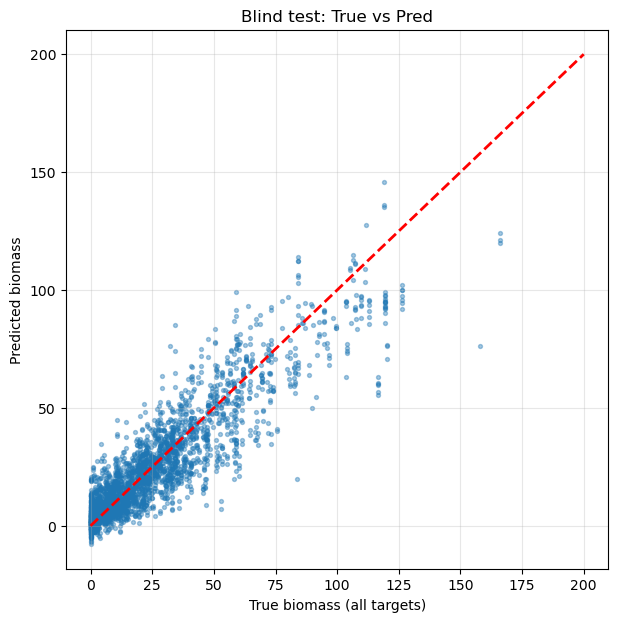

In [29]:
# ============================================================
# Blind Test Evaluation Loop
# ============================================================

from sklearn.model_selection import GroupShuffleSplit

K = 8  # número de rodadas de teste cego
test_fraction = 0.20  # 20% do dataset para teste cego

# Garantir que wide tenha month e Season
wide["month"] = wide["Sampling_Date"].dt.month
wide["Season"] = wide["Sampling_Date"].dt.month % 12 // 3 + 1

all_preds = []
all_true  = []
all_image_ids = []

print(f"\nRunning {K} blind-test rounds...\n")

for round_idx in range(K):

    print(f"\n============== Round {round_idx+1}/{K} ==============\n")

    # ---------------------------------------
    # Divisão cega: não treinamos nas imagens do teste
    # ---------------------------------------
    gss = GroupShuffleSplit(n_splits=1, test_size=test_fraction, random_state=42 + round_idx)
    train_idx, blind_idx = next(gss.split(wide, groups=wide["image_id"]))

    wide_train_local = wide.iloc[train_idx].reset_index(drop=True)
    wide_blind       = wide.iloc[blind_idx].reset_index(drop=True)


    # ---------------------------------------
    # Preparar preprocessamento tabular
    # ---------------------------------------
    # aplicar as mesmas features num/cat definidas antes
    X_train_tab_local = preprocessor.fit_transform(wide_train_local)
    X_blind_tab       = preprocessor.transform(wide_blind)

    # image embeddings
    X_train_img_local = wide_train_local[emb_cols].values.astype("float32")
    X_blind_img       = wide_blind[emb_cols].values.astype("float32")

    y_train_local     = wide_train_local[target_order].values.astype("float32")
    y_blind_real      = wide_blind[target_order].values.astype("float32")

    # ---------------------------------------
    # Criar datasets & dataloaders
    # ---------------------------------------
    ds_train_local = PastureDataset(X_train_tab_local, X_train_img_local, y_train_local)
    ds_val_local   = PastureDataset(X_blind_tab,    X_blind_img,    y_blind_real)  # TEMP val

    train_loader_local = DataLoader(ds_train_local, batch_size=32, shuffle=True)
    val_loader_local   = DataLoader(ds_val_local,   batch_size=32, shuffle=False)

    # ---------------------------------------
    # Criar novo modelo (zerado)
    # ---------------------------------------
    model_local = MultimodalNet(
        tab_dim=X_train_tab_local.shape[1],
        img_dim=X_train_img_local.shape[1]
    ).to(device)

    optimizer_local = AdamW(model_local.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler_local = CosineAnnealingLR(optimizer_local, T_max=50)

    # ---------------------------------------
    # Treinar usando seu train_model
    # ---------------------------------------
    model_local = train_model(
        model=model_local,
        train_loader=train_loader_local,
        val_loader=val_loader_local,  # avaliação temporária
        criterion=criterion,
        optimizer=optimizer_local,
        scheduler=scheduler_local,
        device=device,
        epochs=50,
        patience=8,
        weights_dict=weights_dict,
    )

    # ---------------------------------------
    # Predizer na amostra cega
    # ---------------------------------------
    model_local.eval()
    blind_loader = DataLoader(
        PastureDataset(X_blind_tab, X_blind_img),
        batch_size=64,
        shuffle=False
    )

    preds_round = []

    with torch.no_grad():
        for x_tab, x_img in blind_loader:
            p = model_local(x_tab.to(device), x_img.to(device))
            preds_round.append(p.cpu().numpy())

    preds_round = np.vstack(preds_round)

    # ---------------------------------------
    # Armazenar para análise posterior
    # ---------------------------------------
    all_preds.append(preds_round)
    all_true.append(y_blind_real)
    all_image_ids.append(wide_blind["image_id"].values)

# ============================================================
# Concatenar resultados das K rodadas
# ============================================================

all_preds = np.vstack(all_preds)
all_true  = np.vstack(all_true)
all_image_ids = np.concatenate(all_image_ids)

print("\nBlind test combined shape:", all_preds.shape)

# ------------------------------------------------------------
# Métricas finais
# ------------------------------------------------------------
RMSE_final = np.sqrt(np.mean((all_preds - all_true)**2))
R2_final   = 1 - np.sum((all_true - all_preds)**2) / np.sum((all_true - np.mean(all_true, axis=0))**2)
R2w_final  = weighted_r2_score(all_true, all_preds, weights_dict)

print("\n===== Final Blind-Test Metrics =====")
print("RMSE:", RMSE_final)
print("R² (global):", R2_final)
print("Weighted R² (Kaggle metric):", R2w_final)

# ------------------------------------------------------------
# Plot real vs pred
# ------------------------------------------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))
plt.scatter(all_true.flatten(), all_preds.flatten(), s=8, alpha=0.4)
plt.xlabel("True biomass (all targets)")
plt.ylabel("Predicted biomass")
plt.title("Blind test: True vs Pred")
plt.plot([0, 200], [0, 200], "r--", lw=2)
plt.grid(alpha=0.3)
plt.show()


---
# Disclosure of this NB: The Multimodal Model built here performs well. But what about when you have to predict using only an image?
---

Although the multimodal (tabular + image) model performed very well in blind local validation -- achieving strong correlations and high weighted R^2 -- its score on the Kaggle private test set was significantly lower.
This discrepancy is a consequence of the dataset design.

# 1. The training dataset provides full tabular metadata

`Species`

`NDVI`

`State`

`Height_Ave`

`Sampling_Date → month/season`

- These features are highly predictive of biomass. When the model has access to them during training, performance is naturally strong.

---------------------------------------------------

# 2. The Kaggle test set does not include these tabular features

Thus, any model that relies partially on tabular features will face domain shift at inference.

---------------------------------------------------
# 3. Why does the competition hide tabular metadata from the test set?

Because the challenge is meant to simulate real-world deployment:

- In the field, you take a photo of a pasture.
- You do not know species labels, height, or NDVI.
- The model must infer biomass from the image alone.

Therefore, tabular features in the training set serve as supervision signals, not as inputs to the final predictive pipeline.

------------------------------------------------------------------------------------

# Now: Notebook 04

Build a multimodal architecture that is fully test-compatible:

- Multimodal fusion (same architecture as notebook 03)
- Tabular Dropout (randomly drop tabular features during training)

→ forces the model to rely on image embeddings
→ but still allows tabular guidance during training
→ prevents domain shift

- Robust Blind Validation Loop:

    - Multiple blind splits
    - Train on each
    - Predict on held-out images
    - Aggregate R^2, RMSE, and weighted R²
    - Produce true-vs-pred plots

This approach ensures:

- No leakage
- Honest estimation of real Kaggle performance
- Smooth transition from multimodal supervision → image-only inference